# Center Cut Label Image

In [1]:
!pip install scikit-image

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
     |████████████████████████████████| 26.5 MB 53.7 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 50.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.3 MB 53.7 MB/s eta 0:00:01
     |████████████████████████████████| 4.4 MB 56.5 MB/s eta 0:00:01


In [2]:
from itertools import groupby, chain
from PIL import Image
import matplotlib.pyplot as plt
import cv2 
import numpy as np
from skimage import io, color
import sys
from skimage import img_as_ubyte
import skimage.io as io
import os
np.set_printoptions(threshold=sys.maxsize)

### Commong Utility Functions

In [3]:
#from utilities.model_errors import ValidationError
def find_centermost_mask_bkup(input_mask, min_pixels):
    """
    Take in a binary mask and return a mask of the same shape, with only the centermost contiguous portion.
    If a mask contains no contours (objects), then just return it (it's all zeros anyway).
    """

    # Get all the bits aligned in memory
    input_mask = np.ascontiguousarray(input_mask, dtype=np.uint8)
    contours, _ = cv2.findContours(input_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours or len(contours) == 1:
        return input_mask

    moments = [cv2.moments(contour) for contour in contours]
    # (x, y) tuples of centroid locations for contours (that have area > 0)
    centroids = [
        (m['m10'] / m['m00'], m['m01'] / m['m00'])
        if m['m00'] and m['m00'] >= min_pixels else (0, 0)
        for m in moments
    ]

    if not centroids:
        raise ValidationError(f'No identified footprint contours contain more than {min_pixels} pixels.')

    # dimensions come 1-indexed, but array indicies are 0-indexed
    center = [(dim - 1) / 2 for dim in input_mask.shape]

    # Cacluate (Manhattan) distance from center of image
    distances_from_center = [abs(x - center[0]) + abs(y - center[1]) for x, y in centroids]
    centermost_contour = contours[distances_from_center.index(min(distances_from_center))]

    output_mask = np.zeros(input_mask.shape)
    cv2.fillPoly(output_mask, centermost_contour.transpose((1, 0, 2)), 1)

    return output_mask

In [62]:
#from utilities.model_errors import ValidationError
def find_centermost_mask(input_mask, min_pixels = 10000):
    """
    Take in a binary mask and return a mask of the same shape, with only the centermost contiguous portion.
    If a mask contains no contours (objects), then just return it (it's all zeros anyway).
    """

    # Get all the bits aligned in memory
    input_mask = np.ascontiguousarray(input_mask, dtype=np.uint8)
    contours, _ = cv2.findContours(input_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#     if not contours or len(contours) == 0:
#         output_mask = np.zeros(input_mask.shape)
#         return output_mask

    moments = [cv2.moments(contour) for contour in contours]
    
#     big_contour_area_idx = 0
#     if len(contours) > 1:
#         contour_areas = [m['m00'] for m in moments]
#         big_contour_area_idx = contour_areas.index(max(contour_areas))
#------------------------------------------------------------------    
    # (x, y) tuples of centroid locations for contours (that have area > 0)
    
    for m in moments:
        print('m[00] :',m['m00'])
    
    min_pixels = 10000
#     centroids = []
#     for m in moments:
#         if m['m00'] >= min_pixels:
#             print('selected countour area : ', m['m00'])
#             centroids.append((m['m10'] / m['m00'], m['m01'] / m['m00']))
#         else:
#             print('rejected countour area : ', m['m00'])
#             centroids.append((0,0))
            
#     print('centroids', centroids)
    
    centroids = [
        (m['m10'] / m['m00'], m['m01'] / m['m00'])
        if m['m00'] >= min_pixels else (0, 0)
        for m in moments
    ]

    if not centroids:
        raise ValidationError(f'No identified footprint contours contain more than {min_pixels} pixels.')

    # dimensions come 1-indexed, but array indicies are 0-indexed
    center = [(dim - 1) / 2 for dim in input_mask.shape]

    # Cacluate (Manhattan) distance from center of image
    distances_from_center = [abs(x - center[0]) + abs(y - center[1]) for x, y in centroids]
    centermost_contour = contours[distances_from_center.index(min(distances_from_center))]
    idx = distances_from_center.index(min(distances_from_center))
#     print('center most contour idx : ', moments[idx]['m00'])
#------------------------------------------------------------------

#     centermost_contour = contours[big_contour_area_idx]
    output_mask = np.zeros(input_mask.shape)
    cv2.fillPoly(output_mask, centermost_contour.transpose((1, 0, 2)), 1)

    return output_mask

### Center cut the Prediction Image and Center Cut the Original Image

In [4]:
pred_img_path = pred_path = f'/home/ec2-user/SageMaker/data/footprint/mohan-func-test-run-data/test-run'
pred_cc_save_path = '/home/ec2-user/SageMaker/data/footprint/mohan-func-test-run-data/test-run-cc'

# label_img_path = '/home/ec2-user/SageMaker/data/footprint/190-test-images-label'

In [5]:
lst_pred_imgs = [img for img in os.listdir(pred_img_path) if os.path.isfile(os.path.join(pred_img_path, img))]
lst_pred_imgs, len(lst_pred_imgs)

(['image_395_pred_binary.png',
  'image_289_pred_binary.png',
  'image_243_pred_binary.png',
  'image_224_pred_binary.png',
  'image_127_pred_binary.png'],
 5)

processing : 1, Image Name : image_395_pred_binary.png
(array([ 30, 215], dtype=uint8), array([211162,  50982]))
(512, 512)


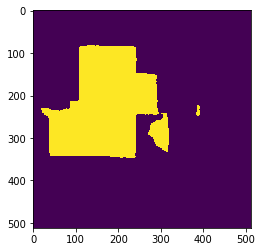

no. of contours from source :  3
(array([  0, 255], dtype=uint8), array([211162,  50982]))


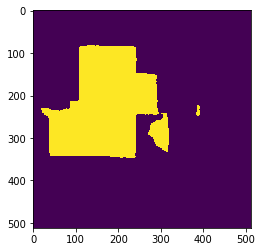

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


before byte conversion  [0. 1.]
(array([0., 1.]), array([259345,   2799]))


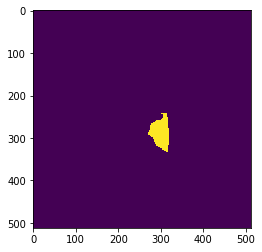

********************************************************************************
processing : 2, Image Name : image_289_pred_binary.png
(array([ 30, 215], dtype=uint8), array([222626,  39518]))
(512, 512)


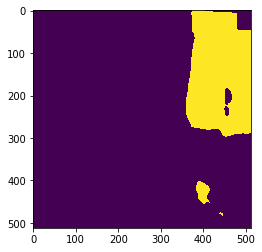

no. of contours from source :  3
(array([  0, 255], dtype=uint8), array([222626,  39518]))


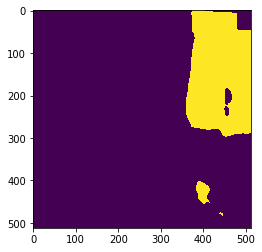

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


before byte conversion  [0. 1.]
(array([0., 1.]), array([223148,  38996]))


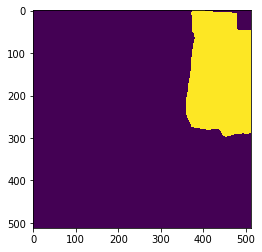

********************************************************************************
processing : 3, Image Name : image_243_pred_binary.png
(array([ 30, 215], dtype=uint8), array([238517,  23627]))
(512, 512)


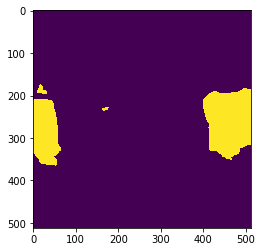

no. of contours from source :  4
(array([  0, 255], dtype=uint8), array([238517,  23627]))


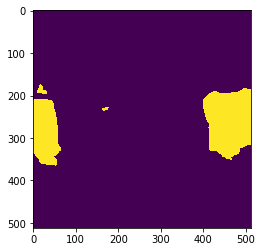

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


before byte conversion  [0. 1.]
(array([0., 1.]), array([247282,  14862]))


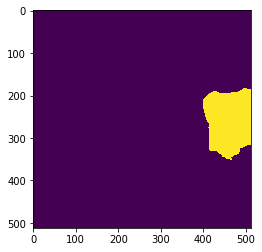

********************************************************************************
processing : 4, Image Name : image_224_pred_binary.png
(array([ 30, 215], dtype=uint8), array([165154,  96990]))
(512, 512)


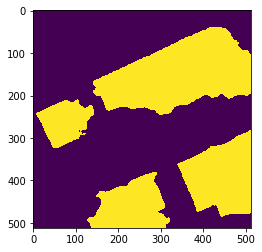

no. of contours from source :  4
(array([  0, 255], dtype=uint8), array([165154,  96990]))


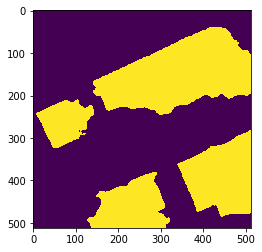

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


before byte conversion  [0. 1.]
(array([0., 1.]), array([252449,   9695]))


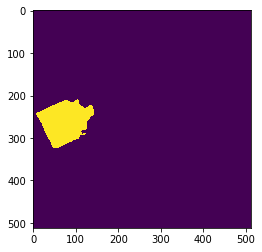

********************************************************************************
processing : 5, Image Name : image_127_pred_binary.png
(array([ 30, 215], dtype=uint8), array([194517,  67627]))
(512, 512)


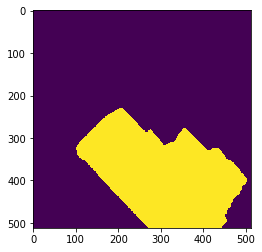

no. of contours from source :  1
(array([  0, 255], dtype=uint8), array([194517,  67627]))


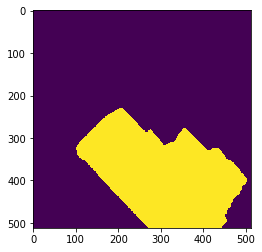

before byte conversion  [  0 255]
(array([  0, 255], dtype=uint8), array([194517,  67627]))


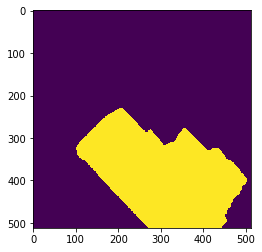

********************************************************************************


In [6]:
for idx, pred_img_name in enumerate(lst_pred_imgs, start=1):
    print('processing : {}, Image Name : {}'.format(idx, pred_img_name))
    pred_img_path_with_filename = os.path.join(pred_img_path, pred_img_name)
    pred_gray = cv2.imread(pred_img_path_with_filename)
    pred_gray = cv2.cvtColor(pred_gray, cv2.COLOR_BGR2GRAY)
    
    unique_values = np.unique(pred_gray)
    print(np.unique(pred_gray,  return_counts=True))
    print(pred_gray.shape)
    plt.imshow(pred_gray)
    plt.show()

#     _, thresh = cv2.threshold(pred_gray, 127, 255, 0)
    _, thresh = cv2.threshold(pred_gray, unique_values[0] + 1, 255, 0)
#     pred_gray[pred_gray < 31] = 0
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print('no. of contours from source : ', len(contours))
    print(np.unique(thresh, return_counts=True))
    plt.imshow(thresh)
    plt.show()
    
    pred_cc_img_mask=find_centermost_mask_bkup(thresh,100)
    print('before byte conversion ', np.unique(pred_cc_img_mask))
#     pred_cc_img_mask = pred_cc_img_mask.astype(np.byte)
#     print('after byte conversion ', np.unique(pred_cc_img_mask))
    io.imsave(os.path.join(pred_cc_save_path, pred_img_name.replace('_pred_binary', '_cc')), pred_cc_img_mask)
    print(np.unique(pred_cc_img_mask, return_counts=True))
    plt.imshow(pred_cc_img_mask)
    plt.show()
    print('*' * 80)

In [22]:
len(lst_pred_imgs)

2

In [29]:
lst_pred_imgs[0]

'image_207_pred_binary.png'

[ 30 215]


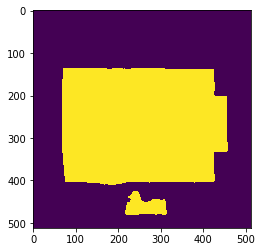

[  0 255]


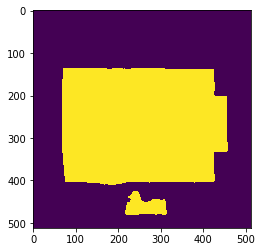

1


In [24]:
pred_img_path_with_filename = os.path.join(pred_img_path, lst_pred_imgs[2])
pred_gray = cv2.imread(pred_img_path_with_filename)
pred_gray = cv2.cvtColor(pred_gray, cv2.COLOR_BGR2GRAY)

print(np.unique(pred_gray))
plt.imshow(pred_gray)
plt.show()
ret, thresh = cv2.threshold(pred_gray, 127, 255, 0)
print(np.unique(thresh))
plt.imshow(thresh)
plt.show()

contours, _ = cv2.findContours(pred_gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

In [71]:
cv2.drawContours??

In [124]:
pred_gray.shape

(512, 512)

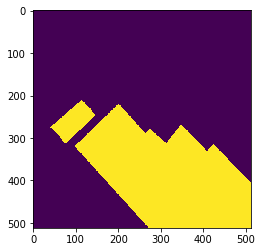

gray unique :  [ 0 29]
thresh unique :  [  0 255]
2
no. of contours  2
type(moments) :  <class 'list'>
moments [{'m00': 71617.0, 'm10': 22677198.833333332, 'm01': 27858541.833333332, 'm20': 7917455604.0, 'm11': 9074543587.833332, 'm02': 11166103875.0, 'm30': 2974999778951.35, 'm21': 3235998190627.9, 'm12': 3728594875781.533, 'm03': 4598014258213.45, 'mu20': 736823255.1647425, 'mu11': 253262434.4586525, 'mu02': 329314382.56687355, 'mu30': 1349808821.5375977, 'mu21': -4228757220.505432, 'mu12': -4136207863.205185, 'mu03': -1728944142.8076172, 'nu20': 0.14365841648169086, 'nu11': 0.049378572179420814, 'nu02': 0.06420641910063665, 'nu30': 0.000983403954597183, 'nu21': -0.0030808633840007844, 'nu12': -0.0030134364991617774, 'nu03': -0.0012596232001046293}, {'m00': 4841.0, 'm10': 455336.0, 'm01': 1265105.5, 'm20': 45347663.5, 'm11': 117616637.0, 'm02': 332882913.3333333, 'm30': 4738949152.0, 'm21': 11590000426.183332, 'm12': 30591744192.25, 'm03': 88181322324.55, 'mu20': 2519555.07281553, 'm

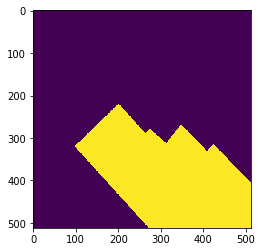

In [48]:
min_pixels = 2000

pred_img_path_with_filename = os.path.join(pred_img_path, lst_pred_imgs[3])
pred_gray = cv2.imread(pred_img_path_with_filename)
pred_gray = cv2.cvtColor(pred_gray, cv2.COLOR_BGR2GRAY)

plt.imshow(pred_gray)
plt.show()

print("gray unique : ", np.unique(pred_gray))
ret, thresh = cv2.threshold(pred_gray, 25, 255, 0)
print("thresh unique : ",np.unique(thresh))
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

# if not contours or len(contours) == 1:
#     print('no contours')
#     return input_mask

print('no. of contours ', len(contours))
moments = [cv2.moments(contour) for contour in contours]
print('type(moments) : ', type(moments))
print('moments', moments)
print('moments[00]', type(moments[0]))

contour_area_seq = [m['m00'] for m in moments]
idx = contour_area_seq.index(max(contour_area_seq))
print('big idx : ', idx)

# (x, y) tuples of centroid locations for contours (that have area > 0)
centroids = [
    (m['m10'] / m['m00'], m['m01'] / m['m00'])
    if m['m00'] and m['m00'] >= min_pixels else (0, 0)
    for m in moments
]


if not centroids:
    raise ValidationError(f'No identified footprint contours contain more than {min_pixels} pixels.')

# dimensions come 1-indexed, but array indicies are 0-indexed
print('thresh.shape : ', thresh.shape)
center = [(dim - 1) / 2 for dim in thresh.shape]
print('center : ', center)
print('centroids : ', centroids)

# Cacluate (Manhattan) distance from center of image
distances_from_center = [abs(x - center[0]) + abs(y - center[1]) for x, y in centroids]
print('distances_from_center : ', distances_from_center)
centermost_contour = contours[distances_from_center.index(min(distances_from_center))]

centermost_contour = contours[idx]

output_mask = np.zeros(thresh.shape)
print('centermost_contour : ', centermost_contour.shape)
# print('centermost_contour', centermost_contour)
tes = centermost_contour.transpose((1, 0, 2))
print('centermost_contour after transpose : ', tes.shape)                                   
# print('tes ', tes)
cv2.fillPoly(output_mask, centermost_contour.transpose((1, 0, 2)), 1)

plt.imshow(output_mask)
plt.show()

# output = np.nonzero()

# print('contour[0] : ', contours[0])
# img1 = cv2.drawContours(pred_gray, contours, 0, (0,0,255), 2)
# plt.imshow(img1)
# plt.show()

# # print('contour[1] : ', contours[1])
# img2 = cv2.drawContours(pred_gray, contours, 1, (0,255,0), 1)
# plt.imshow(img2)
# plt.show()

In [13]:
out_img = np.zeros((pred_gray.shape[0],pred_gray.shape[1]), dtype=np.uint8)
print(out_img.shape)
print(np.unique(out_img))

(512, 512)
[0]


contour[0] :  [[[166 113]]

 [[166 114]]

 [[165 115]]

 [[165 116]]

 [[164 117]]

 [[164 118]]

 [[163 119]]

 [[163 120]]

 [[162 121]]

 [[162 122]]

 [[161 123]]

 [[161 125]]

 [[160 126]]

 [[160 127]]

 [[159 128]]

 [[159 129]]

 [[157 131]]

 [[157 132]]

 [[156 133]]

 [[156 134]]

 [[155 135]]

 [[155 136]]

 [[154 137]]

 [[154 138]]

 [[153 139]]

 [[153 140]]

 [[149 144]]

 [[149 145]]

 [[148 146]]

 [[148 150]]

 [[147 151]]

 [[147 153]]

 [[137 163]]

 [[136 163]]

 [[136 167]]

 [[137 168]]

 [[137 174]]

 [[136 175]]

 [[136 176]]

 [[135 177]]

 [[135 178]]

 [[133 180]]

 [[133 181]]

 [[131 183]]

 [[131 184]]

 [[130 185]]

 [[130 186]]

 [[129 187]]

 [[129 188]]

 [[127 190]]

 [[127 191]]

 [[125 193]]

 [[125 194]]

 [[123 196]]

 [[123 197]]

 [[121 199]]

 [[121 200]]

 [[119 202]]

 [[119 203]]

 [[115 207]]

 [[115 208]]

 [[113 210]]

 [[113 211]]

 [[109 215]]

 [[109 216]]

 [[107 218]]

 [[107 219]]

 [[103 223]]

 [[103 224]]

 [[100 227]]

 [[100

TypeError: unhashable type: 'numpy.ndarray'

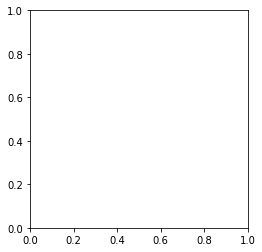

In [10]:
print('contour[0] : ', contours[0])
cv2.drawContours(out_img, contours, 0, (0,0,255), 2)
plt.imshow(out_img)
plt.show()

In [42]:
test  = [{'m1': 10, 'm2' : 20, 'total' : 30}, {'m1': 20, 'm2' : 20, 'total' : 40}]

In [43]:
seq = [dic['total'] for dic in test]

In [44]:
seq

[30, 40]

In [45]:
max(seq)

40

In [46]:
seq.index(max(seq))

1